# Gaussian Clouds

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from regimedetection.examples.gaussianclouds.utils import make_gaussian_clouds
from regimedetection.src.clustering import delta_k_t
from regimedetection.src.clustering import get_similarities_matrix
from regimedetection.src.clustering import get_space_distances
from regimedetection.src.clustering import get_space_similarities
from regimedetection.src.clustering import get_transition_matrix_from_similarities_matrix
from regimedetection.src.clustering import multiscale_k_prototypes
from regimedetection.src.metrics import euclidean_distance
from regimedetection.src.utils.plot import make_colours

### Example Setup

In [2]:
np.random.seed(0)

In [3]:
cluster_centres = (
    (1, 1),
    (3, 8),
    (8, 2),
    (9, 9)
)

points_per_cluster = 50
cluster_std_dev = 1.5

In [4]:
MAX_SUGGESTED_CLUSTERS = 10
MAX_STEPS_POWER = 8

In [5]:
metric = euclidean_distance
similarity = lambda x: 1/(x*x*x)

### Generate and Display Example Points

In [6]:
points = make_gaussian_clouds(
    cluster_centres,
    points_per_cluster,
    std_dev = cluster_std_dev
)

In [7]:
sns.set_style("dark")

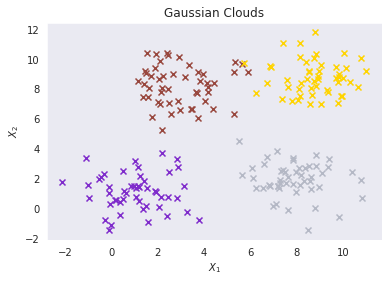

In [8]:
n_clusters = len(cluster_centres)
n_required_colours = max(n_clusters, MAX_SUGGESTED_CLUSTERS)
colours = make_colours(n_required_colours)

for n in range(n_clusters):
    colour = colours[n]
    cluster_points = points[n*points_per_cluster:(n+1)*points_per_cluster]
    plt.scatter(
        cluster_points[:,0],
        cluster_points[:,1],
        color = colour,
        label = n,
        marker = 'x'
    )

plt.title("Gaussian Clouds")
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.show()

### Eigengap plot

In [9]:
similarities_matrix = get_similarities_matrix(
    points, metric, similarity
)

transition_matrix = get_transition_matrix_from_similarities_matrix(
    similarities_matrix
)

In [10]:
evalues = np.linalg.eig(transition_matrix)[0]

# Sort eigenvalues from largest to smallest
idx = evalues.argsort()[::-1]
evalues = evalues[idx]

In [11]:
# Cluster numbers considered - most general would be {1, ..., N} where
# N = number of points
k_values = np.arange(1, MAX_SUGGESTED_CLUSTERS+1)

# Number of steps considered - could be more clever about this and infer
# from the dataset what the maximum number of steps should be, e.g. by
# checking when the 1-clustering starts to be the recommendation
t_values = np.logspace(start=0, stop=MAX_STEPS_POWER, num=1000)

$\Delta_K(t) = |\lambda_{K}|^t - |\lambda_{K+1}|^t$ for $k \in \{1, 2, \ldots, \textrm{maxSuggestedClusters}\}$, $0 \leq t \leq 10^{\textrm{maxStepsPower}}$

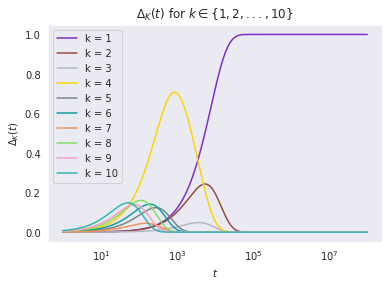

In [12]:
delta_k_t_values = delta_k_t(k_values, t_values, evalues)

for idx, k in enumerate(k_values):
    plt.plot(
        t_values,
        delta_k_t_values[idx],
        label=f"k = {k}",
        color = colours[idx]
    )
    
if len(k_values) <= 5:
    plot_title = "$\Delta_K(t)$ for $k \in \{" + ", ".join(str(x) for x in k_values) + "\}$" 
elif len(k_values) > 5:
    plot_title = "$\Delta_K(t)$ for $k \in \{1, 2, ..., " + str(max(k_values)) + "\}$"

plt.xscale("log")
plt.xlabel("$t$")
plt.ylabel("$\Delta_K(t)$")
plt.title(plot_title)
plt.legend()
plt.show()

$\Delta(t) = \max_{K} \Delta_K(t)$ for $0 \leq t \leq 10^{\textrm{maxStepsPower}}$:

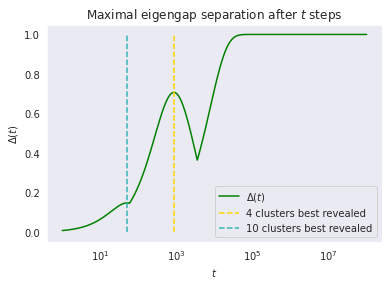

In [13]:
delta_t_values = delta_k_t_values.max(axis=0)

plt.plot(t_values, delta_t_values, label="$\Delta(t)$", color="green")

# Add lines to show local maxima of delta_k_t for appropriate values of k
for idx, t_idx in enumerate(delta_k_t_values.argmax(axis=1)):
    if idx == 0:
        continue
    
    k = k_values[idx]
    t = t_values[t_idx]
    
    if delta_k_t_values[:, t_idx].argmax(axis=0) == idx:
        plt.plot(
            [t, t],
            [0, 1],
            label=f"{k} clusters best revealed",
            color=colours[idx],
            linestyle="dashed"
        )

plt.title("Maximal eigengap separation after $t$ steps")
plt.xlabel("$t$")
plt.ylabel("$\Delta(t)$")

plt.xscale("log")
plt.legend()
plt.show()

Number of clusters best revealed by $t$ steps, $K(t)$:

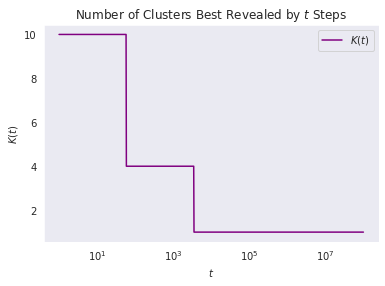

In [14]:
clusters_best_revealed = delta_k_t_values.argmax(axis=0) + 1

plt.plot(t_values, clusters_best_revealed, label="$K(t)$", color="purple")

plt.title("Number of Clusters Best Revealed by $t$ Steps")
plt.xlabel("$t$")
plt.ylabel("$K(t)$")

plt.xscale("log")
plt.legend()
plt.show()

### Clustering

In [15]:
suggested_partitions = multiscale_k_prototypes(
    transition_matrix,
    max_steps_power = MAX_STEPS_POWER,
    max_clusters = MAX_SUGGESTED_CLUSTERS
)

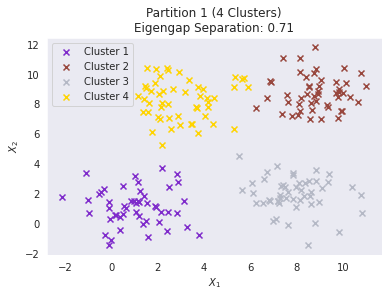

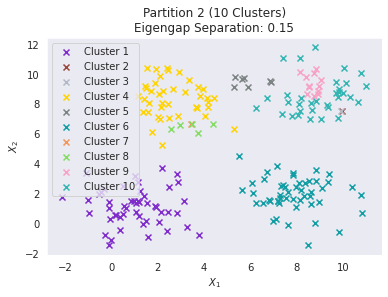

In [16]:
for partition_idx, (partition, partition_suitability) in enumerate(suggested_partitions):
    for cluster_idx, cluster_indices in enumerate(partition):
        cluster_colour = colours[cluster_idx]
        predicted_cluster_points = points[cluster_indices]
        plt.scatter(
            predicted_cluster_points[:,0],
            predicted_cluster_points[:,1],
            color = cluster_colour,
            label = f"Cluster {cluster_idx+1}",
            marker = 'x'
        )
        
    plot_title = f"Partition {partition_idx+1} ({len(partition)} Clusters)"
    plot_title += f"\nEigengap Separation: {round(partition_suitability, 2)}"
    
    plt.xlabel('$X_1$')
    plt.ylabel('$X_2$')
    plt.title(plot_title)
    plt.legend()
    plt.show()